In [1]:
import csv
import sys
import os
import pickle
import random
import time
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
sys.path.append('../python')
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict
from utils.utils_funcs import aggregate_embeddings_visual_and_language

In [ ]:
save_fig=False

In [5]:
# adapted from permutation.py
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def compute_alignment_strength(z_0,z_1,return_poss=False):
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    if return_poss:
        return spearmanr(upper_tri_indexing(sim_z_0), upper_tri_indexing(sim_z_1))
    else:
        return spearmanr(upper_tri_indexing(sim_z_0), upper_tri_indexing(sim_z_1))[0]

# adapted from permutation.py
def permutation(z_0,z_1,n_sim=1000,return_poss=False):
    alignment_strength_list=list()
    alignment_strength,p=compute_alignment_strength(z_0,z_1,return_poss=True) #true mapping system
    alignment_strength_list.append(alignment_strength) 
    for i_sim in range(n_sim):
        alignment_strength_list.append(compute_alignment_strength(z_0, np.random.permutation(z_1)))
    count=0
    for ele in alignment_strength_list[1:]:
        if alignment_strength_list[0]>ele:
            count+=1
    relative_alignment_strength=count/(len(alignment_strength_list)-1)
    if return_poss:
        return relative_alignment_strength, alignment_strength_list, p
    else:
        return relative_alignment_strength, alignment_strength_list

def get_alignment_strength_list(struct,concepts,n_sim=1000):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    return permutation(z_0,z_1,n_sim=n_sim,return_poss=True)

In [6]:
def compute_rAS(alignment_strength_list):
    count=0
    for ele in alignment_strength_list[1:]:
        if alignment_strength_list[0]>ele:
            count+=1
    relative_alignment_strength=count/(len(alignment_strength_list)-1)
    return relative_alignment_strength

In [7]:
# sns.set_style('darkgrid')  # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)  # fontsize of the axes title
plt.rc('axes', labelsize=18)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=18)  # legend fontsize
plt.rc('font', size=18)  # controls default text sizes
# plt.figure(figsize=(10, 6), tight_layout=True)

In [8]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings_replication/vg_noun_least20_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings_replication/vg_verb_least20_ll_swav_bert_20.pkl","rb"))

In [10]:
def run_alignment_multiple_runs(noun_data,verb_data,n_sample=1):
    t1=time.time()
    rAS_noun_list=list()
    aAS_noun_list=list()
    # aAS_noun_zscore_list=list()
    p_noun_list=list()
    rAS_verb_list=list()
    aAS_verb_list=list()
    # aAS_verb_zscore_list=list()
    p_verb_list=list()
    
    for run in range(1000):
        selected_noun_data=aggregate_embeddings_visual_and_language(noun_data,n_sample,n_sample)
        # selected_noun_data=get_random_embeddings_visual_and_language(noun_data,1)
        rAS_noun,aAS_noun,p_noun=get_alignment_strength_list(selected_noun_data,selected_noun_data["words"],n_sim=1000)
        rAS_noun_list.append(rAS_noun)
        aAS_noun_list.append(aAS_noun)
        # aAS_noun_zscore_list.append(zscore(aAS_noun))
        p_noun_list.append(p_noun)
        
        selected_verb_data=aggregate_embeddings_visual_and_language(verb_data,n_sample,n_sample)
        # selected_verb_data=get_random_embeddings_visual_and_language(verb_data,1)
        rAS_verb,aAS_verb,p_verb=get_alignment_strength_list(selected_verb_data,selected_verb_data["words"],n_sim=1000)
        rAS_verb_list.append(rAS_verb)
        aAS_verb_list.append(aAS_verb)
        # aAS_verb_zscore_list.append(zscore(aAS_verb))
        p_verb_list.append(p_verb)
    t2=time.time()
    print(t2-t1)
    return rAS_noun_list,aAS_noun_list,p_noun_list,rAS_verb_list,aAS_verb_list,p_verb_list

## Systems with 1 exemplar per category

In [11]:
rAS_noun_list,aAS_noun_list,p_noun_list,rAS_verb_list,aAS_verb_list,p_verb_list=run_alignment_multiple_runs(vg_noun_data,vg_verb_data,1)

10131.67787694931


In [12]:
len([i for i in p_noun_list if i<0.05])/len(p_noun_list),len([i for i in p_verb_list if i<0.05])/len(p_verb_list)

(0.754, 0.601)

In [13]:
np.mean([compute_rAS(sublist) for sublist in aAS_noun_list]),np.mean([compute_rAS(sublist) for sublist in aAS_verb_list])

(0.7611619999999999, 0.6193569999999999)

In [14]:
aAS_true_mapping_noun=[sublist[0] for sublist in aAS_noun_list]
aAS_perm_mapping_noun=[item for sublist in aAS_noun_list for item in sublist[1:]]

aAS_true_mapping_verb=[sublist[0] for sublist in aAS_verb_list]
aAS_perm_mapping_verb=[item for sublist in aAS_verb_list for item in sublist[1:]]

In [15]:
np.mean(aAS_true_mapping_noun),np.mean(aAS_true_mapping_verb)

(0.027483204793942482, 0.010484496297028831)

In [16]:
values=aAS_true_mapping_noun+aAS_perm_mapping_noun+aAS_true_mapping_verb+aAS_perm_mapping_verb
types=["VG Nouns"]*(len(aAS_true_mapping_noun)+len(aAS_perm_mapping_noun))+["VG Verbs"]*(len(aAS_true_mapping_verb)+len(aAS_perm_mapping_verb))
measures=["true mapping"]*len(aAS_true_mapping_noun)+["perm mapping"]*len(aAS_perm_mapping_noun)+["true mapping"]*len(aAS_true_mapping_verb)+["perm mapping"]*len(aAS_perm_mapping_verb)
df=pd.DataFrame(dict(
    value=values,
    wordtype=types,
    measure=measures
))

In [17]:
df

,value,wordtype,measure
0,-0.006646,VG Nouns,true mapping
1,-0.043115,VG Nouns,true mapping
2,0.051684,VG Nouns,true mapping
3,0.037055,VG Nouns,true mapping
4,-0.002540,VG Nouns,true mapping
...,...,...,...
2001995,0.031197,VG Verbs,perm mapping
2001996,0.024104,VG Verbs,perm mapping
2001997,-0.019715,VG Verbs,perm mapping
2001998,-0.034933,VG Verbs,perm mapping


In [18]:
palette_perm_mappings=['#CBCBCB','#CBCBCB']
# palette_true_mappings=['#F4D000','#B6C29A']
palette_true_mappings=[sns.color_palette("gist_stern_r")[0],sns.color_palette("gist_stern_r")[5]]

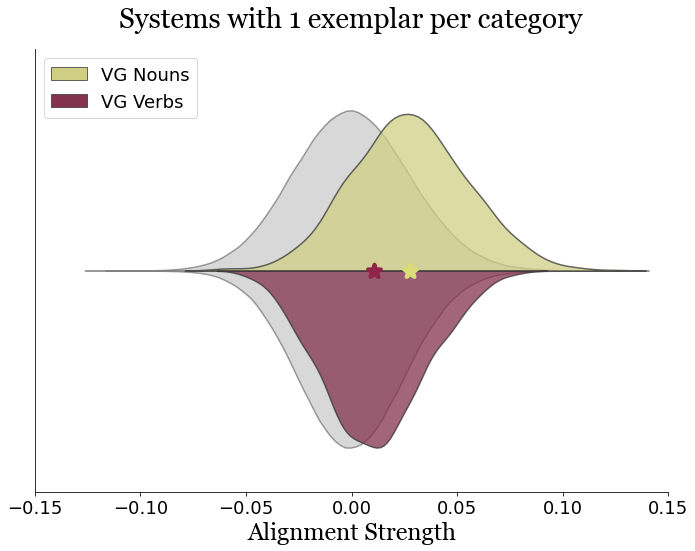

In [58]:
palette = ['#B6C29A', '#8A977B']
# fig, ax =plt.subplots(figsize=(8,6))
plt.subplots(figsize=(10,8))
ax=sns.violinplot(y="measure", x="value", hue="wordtype",
                    data=df[df.measure=="perm mapping"],split=True,palette=palette_perm_mappings,inner=None,legend=False)
sns.violinplot(y="measure", x="value", hue="wordtype",
                    data=df[df.measure=="true mapping"],split=True,palette=palette_true_mappings,inner=None)

sns.pointplot(y="measure", x="value", hue="wordtype",
                    data=df[df.measure=="true mapping"], palette=palette_true_mappings,estimator=np.mean, scale=2, markers=["*","*"])

for violin in ax.collections[:-2]:
    violin.set_alpha(0.75)
    
h,l = ax.get_legend_handles_labels()
ax.legend(h[2:4],l[2:4],loc=2)

sns.despine()
# g.legend(loc=2)
ax.set_ylabel("")
ax.set_xlabel("Alignment Strength",fontsize=24,fontname='Georgia')
ax.set_yticks([])
ax.set_xlim(-0.15, 0.15)
# # ax.get_legend().remove()

plt.text(-0.11,-0.55,'Systems with 1 exemplar per category',fontname='Georgia',fontsize=28)

plt.tight_layout()
if save_fig:
    plt.savefig("../figs/single_alignment_vg.png",dpi=600)
plt.show()

In [62]:
scipy.stats.ttest_ind(aAS_true_mapping_noun,aAS_perm_mapping_noun)

Ttest_indResult(statistic=31.335959689595835, pvalue=1.9235677883208147e-215)

In [63]:
scipy.stats.ttest_ind(aAS_true_mapping_verb,aAS_perm_mapping_verb)

Ttest_indResult(statistic=13.316073629471504, pvalue=1.881576183212437e-40)

## Systems with 8 exemplars per category

In [22]:
rAS_noun_list_agg,aAS_noun_list_agg,p_noun_list_agg,rAS_verb_list_agg,aAS_verb_list_agg,p_verb_list_agg=run_alignment_multiple_runs(vg_noun_data,vg_verb_data,8)

10291.636207818985


In [23]:
len([i for i in p_noun_list_agg if i<0.05])/len(p_noun_list_agg),len([i for i in p_verb_list_agg if i<0.05])/len(p_verb_list_agg)

(1.0, 1.0)

In [24]:
np.mean([compute_rAS(sublist) for sublist in aAS_noun_list_agg]),np.mean([compute_rAS(sublist) for sublist in aAS_verb_list_agg])

(0.999991, 0.9917549999999999)

In [25]:
aAS_true_mapping_noun_agg=[sublist[0] for sublist in aAS_noun_list_agg]
aAS_perm_mapping_noun_agg=[item for sublist in aAS_noun_list_agg for item in sublist[1:]]

aAS_true_mapping_verb_agg=[sublist[0] for sublist in aAS_verb_list_agg]
aAS_perm_mapping_verb_agg=[item for sublist in aAS_verb_list_agg for item in sublist[1:]]

In [26]:
np.mean(aAS_true_mapping_noun_agg),np.mean(aAS_true_mapping_verb_agg)

(0.17499610062407345, 0.09472706134325572)

In [27]:
values_agg=aAS_true_mapping_noun_agg+aAS_perm_mapping_noun_agg+aAS_true_mapping_verb_agg+aAS_perm_mapping_verb_agg
types_agg=["VG Nouns"]*(len(aAS_true_mapping_noun_agg)+len(aAS_perm_mapping_noun_agg))+["VG Verbs"]*(len(aAS_true_mapping_verb_agg)+len(aAS_perm_mapping_verb_agg))
measures_agg=["true mapping"]*len(aAS_true_mapping_noun_agg)+["perm mapping"]*len(aAS_perm_mapping_noun_agg)+["true mapping"]*len(aAS_true_mapping_verb_agg)+["perm mapping"]*len(aAS_perm_mapping_verb_agg)
df_agg=pd.DataFrame(dict(
    value=values_agg,
    wordtype=types_agg,
    measure=measures_agg
))

In [28]:
df_agg

,value,wordtype,measure
0,0.196670,VG Nouns,true mapping
1,0.141882,VG Nouns,true mapping
2,0.192146,VG Nouns,true mapping
3,0.156680,VG Nouns,true mapping
4,0.196914,VG Nouns,true mapping
...,...,...,...
2001995,-0.008294,VG Verbs,perm mapping
2001996,-0.001342,VG Verbs,perm mapping
2001997,0.008698,VG Verbs,perm mapping
2001998,0.061508,VG Verbs,perm mapping


In [29]:
palette_perm_mappings=['#CBCBCB','#CBCBCB']
# palette_true_mappings=['#F4D000','#B6C29A']
palette_true_mappings=[sns.color_palette("gist_stern_r")[0],sns.color_palette("gist_stern_r")[5]]

In [61]:
1000*1000+1000-2

1000998

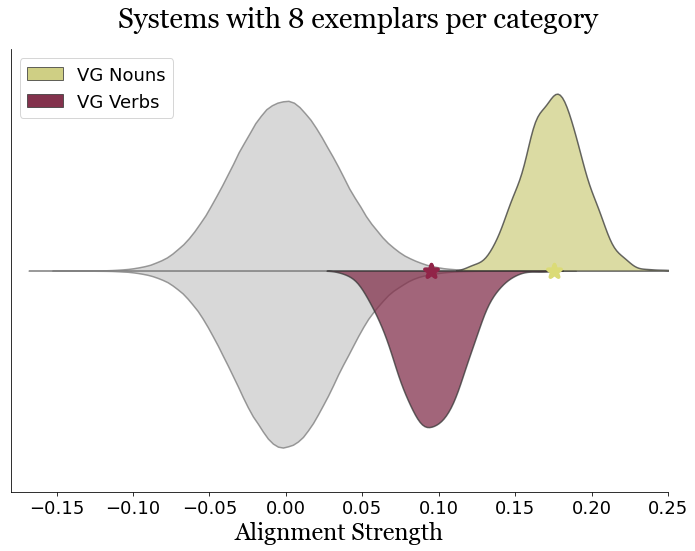

In [59]:
palette = ['#B6C29A', '#8A977B']
# fig, ax =plt.subplots(figsize=(8,6))
plt.subplots(figsize=(10,8))
ax=sns.violinplot(y="measure", x="value", hue="wordtype",
                    data=df_agg[df_agg.measure=="perm mapping"],split=True,palette=palette_perm_mappings,inner=None,legend=False)
sns.violinplot(y="measure", x="value", hue="wordtype",
                    data=df_agg[df_agg.measure=="true mapping"],split=True,palette=palette_true_mappings,inner=None)

sns.pointplot(y="measure", x="value", hue="wordtype",
                    data=df_agg[df_agg.measure=="true mapping"], palette=palette_true_mappings,estimator=np.mean, scale=2, markers=["*","*"])

for violin in ax.collections[:-2]:
    violin.set_alpha(0.75)
    
h,l = ax.get_legend_handles_labels()
ax.legend(h[2:4],l[2:4],loc=2)

sns.despine()
# g.legend(loc=2)
ax.set_ylabel("")
ax.set_xlabel("Alignment Strength",fontsize=24,fontname='Georgia')
ax.set_yticks([])
ax.set_xlim(-0.18, 0.25)
# # ax.get_legend().remove()

plt.text(-0.11,-0.55,'Systems with 8 exemplars per category',fontname='Georgia',fontsize=28)

plt.tight_layout()
if save_fig:
    plt.savefig("../figs/single_alignment_agg_vg.png",dpi=600)
plt.show()

In [33]:
scipy.stats.ttest_ind(aAS_true_mapping_noun_agg,aAS_perm_mapping_noun_agg)

Ttest_indResult(statistic=159.01232681766442, pvalue=0.0)

In [34]:
scipy.stats.ttest_ind(aAS_true_mapping_verb_agg,aAS_perm_mapping_verb_agg)

Ttest_indResult(statistic=89.49101726607384, pvalue=0.0)